In [1]:
import pandas as pd
from transformers import pipeline
from tqdm.notebook import tqdm

In [2]:
df = pd.read_parquet("../lenta.parquet")
df = df[['docid', 'text']].dropna()[:1000]
df.head()

,docid,text
0,1685902,Джо Байден Фото: РИА Новости Марина Совина Уча...
1,1685904,Андрей Белоусов Фото: Kremlin Pool / Global Lo...
2,1685905,Фото: Globallookpress.com Марина Совина Три бе...
3,1685893,Фото: Keystone Press Agency / Globallookpress....
4,1685906,Фото: Globallookpress.com Марина Совина Средст...


# 1.Use pretrained transformers model for sentiment labeling

In [3]:
sentiment_pipeline = pipeline(model='sismetanin/sbert-ru-sentiment-rureviews')
labels = sentiment_pipeline([text[:2000] for text in df['text'].values])
labels = [l['label'] for l in labels]
df['label'] = labels

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [4]:
df['label'].value_counts()

LABEL_1    659
LABEL_0    239
LABEL_2    102
Name: label, dtype: int64

In [5]:
df['target'] = (df['label'] == 'LABEL_1').astype(int)
df.head()

,docid,text,label,target
0,1685902,Джо Байден Фото: РИА Новости Марина Совина Уча...,LABEL_1,1
1,1685904,Андрей Белоусов Фото: Kremlin Pool / Global Lo...,LABEL_1,1
2,1685905,Фото: Globallookpress.com Марина Совина Три бе...,LABEL_1,1
3,1685893,Фото: Keystone Press Agency / Globallookpress....,LABEL_1,1
4,1685906,Фото: Globallookpress.com Марина Совина Средст...,LABEL_0,0


# 2. Text preprocessing

In [6]:
from bs4 import BeautifulSoup
import re
import nltk

In [7]:
def prep(review):
    # Lower case
    review = review.lower()
    
    # Tokenize to each word.
    token = nltk.word_tokenize(review)
    
    # Stemming
    review = [nltk.stem.SnowballStemmer('russian').stem(w) for w in token]
    
    # Join the words back into one string separated by space, and return the result.
    return " ".join(review)

In [8]:
X_train, y_train = df[:700]['text'].apply(prep), df[:700]['target']
X_test, y_test = df[700:]['text'].apply(prep), df[700:]['target']

# 3. Baseline model - TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words

In [10]:
tv = TfidfVectorizer(ngram_range = (1,3),
                     sublinear_tf = True,
                     max_features = 20000)

In [11]:
train_tv = tv.fit_transform(X_train)
test_tv = tv.transform(X_test)

In [12]:
vocab = tv.get_feature_names_out()
print(vocab[:5], len(vocab))

['00' '00 до' '00 до 13' '00 колон' '00 колон растянувш'] 20000


### 3.1 Visualization

In [13]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [14]:
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

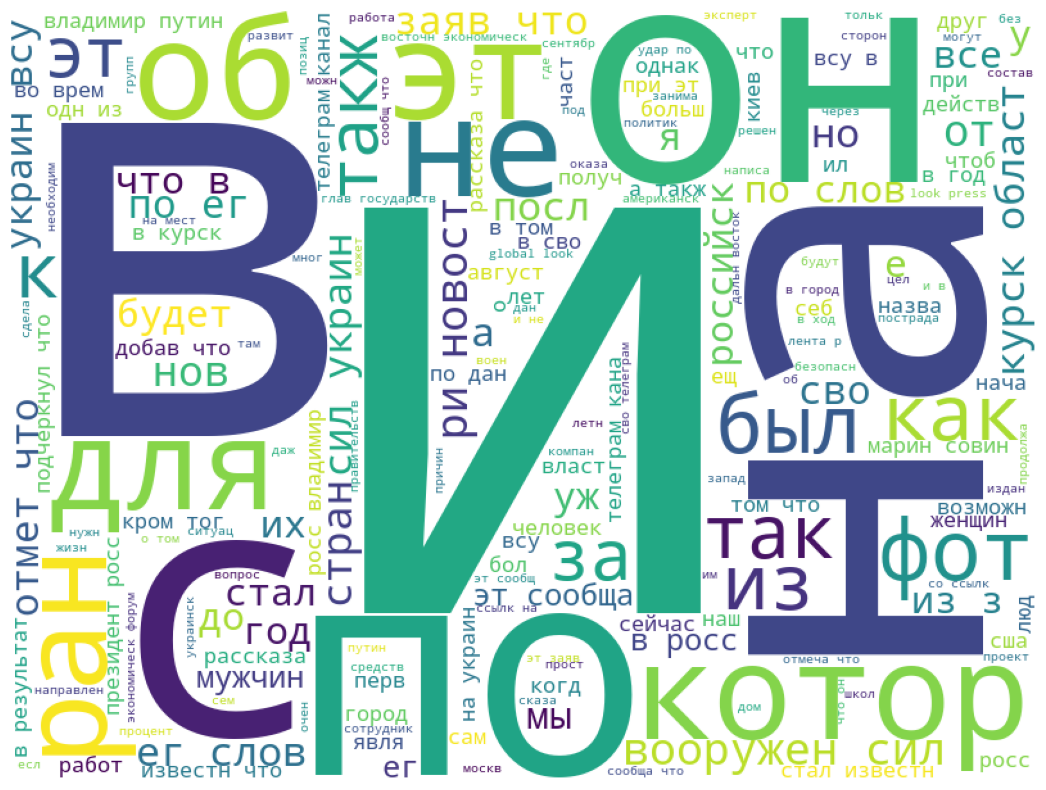

In [15]:
cloud(' '.join(X_train))

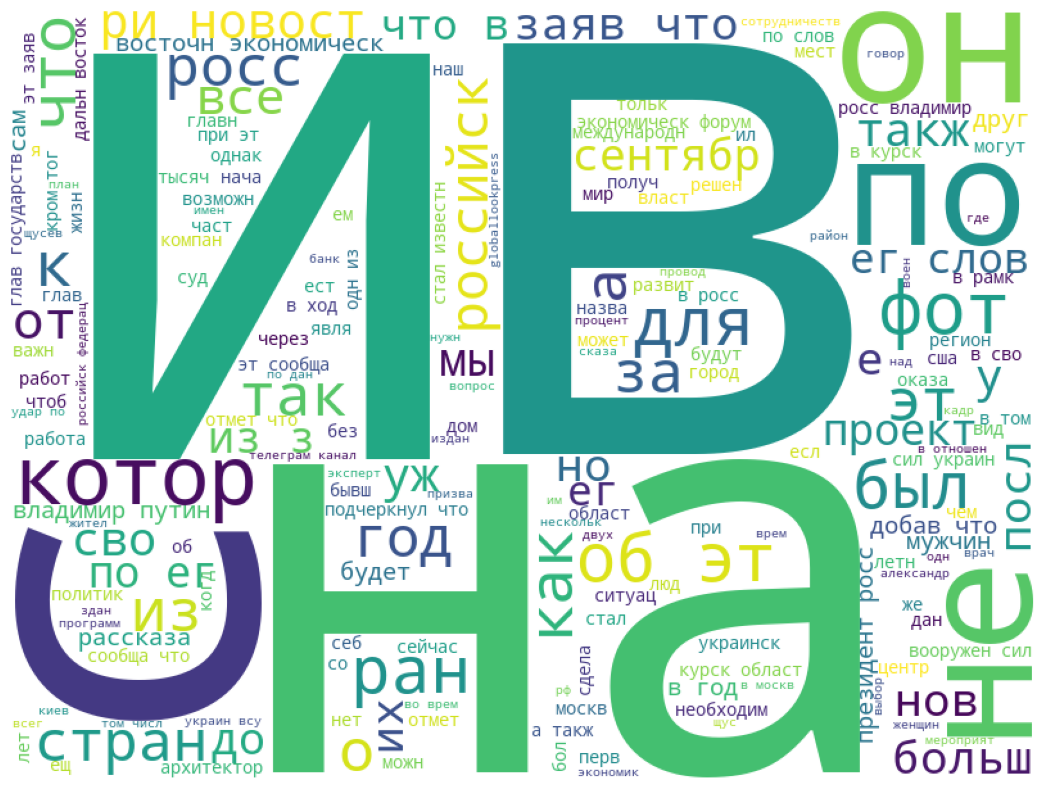

In [16]:
cloud(' '.join(X_test))

### 3.2 Modelling - LogReg

In [17]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression

kfold = StratifiedKFold( n_splits = 5, random_state = 42, shuffle=True )

lr = LogisticRegression(random_state=42)

lr2_param = {
    'penalty':['l2'],
    'dual':[False],
    'C':[6],
    'class_weight':[{1:1}]
}

lr_CV = GridSearchCV(lr, param_grid = [lr2_param], cv = kfold, scoring = 'roc_auc', n_jobs = 1, verbose = 1)
lr_CV.fit(train_tv, y_train)
print(lr_CV.best_params_)
logi_best = lr_CV.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'C': 6, 'class_weight': {1: 1}, 'dual': False, 'penalty': 'l2'}


In [18]:
print(lr_CV.best_score_)

0.8453694067260958
